In [ ]:
pip install xarray rasterio pystac-client planetary-computer pystac rioxarray geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install rioxarray stackstac odc-stac planetary-computer pystac-client matplotlib xarray rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 370.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 11.5 MB/s eta 0:00:00


In [ ]:
!pip install stackstac odc-stac planetary-computer rioxarray rasterio xarray

# Import

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Others
import os
from tqdm import tqdm


In [ ]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


In [ ]:
ground_df["mean_temperature"]  = ground_df["UHI Index"].mean()
ground_df["variance"] = ground_df["UHI Index"].var()
ground_df.head()

,Longitude,Latitude,datetime,UHI Index,mean_temperature,variance
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1.000001,0.000264
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1.000001,0.000264
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1.000001,0.000264
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1.000001,0.000264
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1.000001,0.000264


In [ ]:
mean = ground_df["UHI Index"].mean() # ~1.0000001
var = ground_df["UHI Index"].var() #~0.00026
ground_df["transformed_uhi_index"] = (ground_df["UHI Index"] - mean) / var

In [ ]:
ground_df.head()

,Longitude,Latitude,datetime,UHI Index,transformed_uhi_index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,114.863919
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,114.863919
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,90.246549
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,90.246549
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,82.040760


# Convert tiff to csv


In [ ]:
# prompt: create a more general map_satellite_data function

def map_satellite_data(tiff_path, csv_path, band_names):
    """
    Maps satellite data from a GeoTIFF to coordinates in a CSV file.

    Args:
        tiff_path (str): Path to the GeoTIFF file.
        csv_path (str): Path to the CSV file containing latitude and longitude.
        band_names (list): A list of band names corresponding to the bands in the GeoTIFF.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted band values.
    """
    import warnings
    import numpy as np
    import pandas as pd
    import rioxarray as rxr
    from pyproj import Proj, Transformer
    from tqdm import tqdm

    warnings.filterwarnings('ignore')

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Create coordinate transformers
    proj_wgs84 = Proj(init='epsg:4326')
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Extract band values
    extracted_data = {}
    for band_index, band_name in enumerate(band_names):
        band_values = []
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc=f"Mapping {band_name}"):
            try:
                band_value = data.sel(x=lon, y=lat, band=band_index + 1, method="nearest").values
                band_values.append(band_value)
            except Exception as e:
              print(f"Error processing coordinates ({lat}, {lon}): {e}")
              band_values.append(np.nan) # or handle the error differently

        extracted_data[band_name] = band_values

    return pd.DataFrame(extracted_data)


In [ ]:
final_datas = map_satellite_data('median_bands.tiff', 'Training_data_uhi_index.csv',["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"])

Mapping B12: 100%|██████████| 11229/11229 [00:19<00:00, 571.72it/s]


# Feature Engineer

In [ ]:
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
uhi_data = combine_two_datasets(ground_df,final_datas)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,transformed_uhi_index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,114.863919,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,114.863919,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,90.246549,841.5,646.0,823.0,777.0,1130.5,1883.0,2117.5,2241.0,2251.0,1548.0,1135.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,90.246549,841.5,625.0,766.0,741.5,1130.5,1883.0,2117.5,2200.0,2251.0,1548.0,1135.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,82.040760,841.5,659.5,763.0,708.5,1077.5,1783.0,2042.0,2161.0,2186.0,1617.5,1207.5


In [ ]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'transformed_uhi_index', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B8A', 'B11', 'B12'],
      dtype='object')

In [ ]:
# prompt: find variance of UHI Index

# Calculate the variance of the 'UHI_Index' column
uhi_variance = uhi_data['UHI Index'].var()

print(f"The variance of the UHI Index is: {uhi_variance}")


The variance of the UHI Index is: 0.00026368150562129585


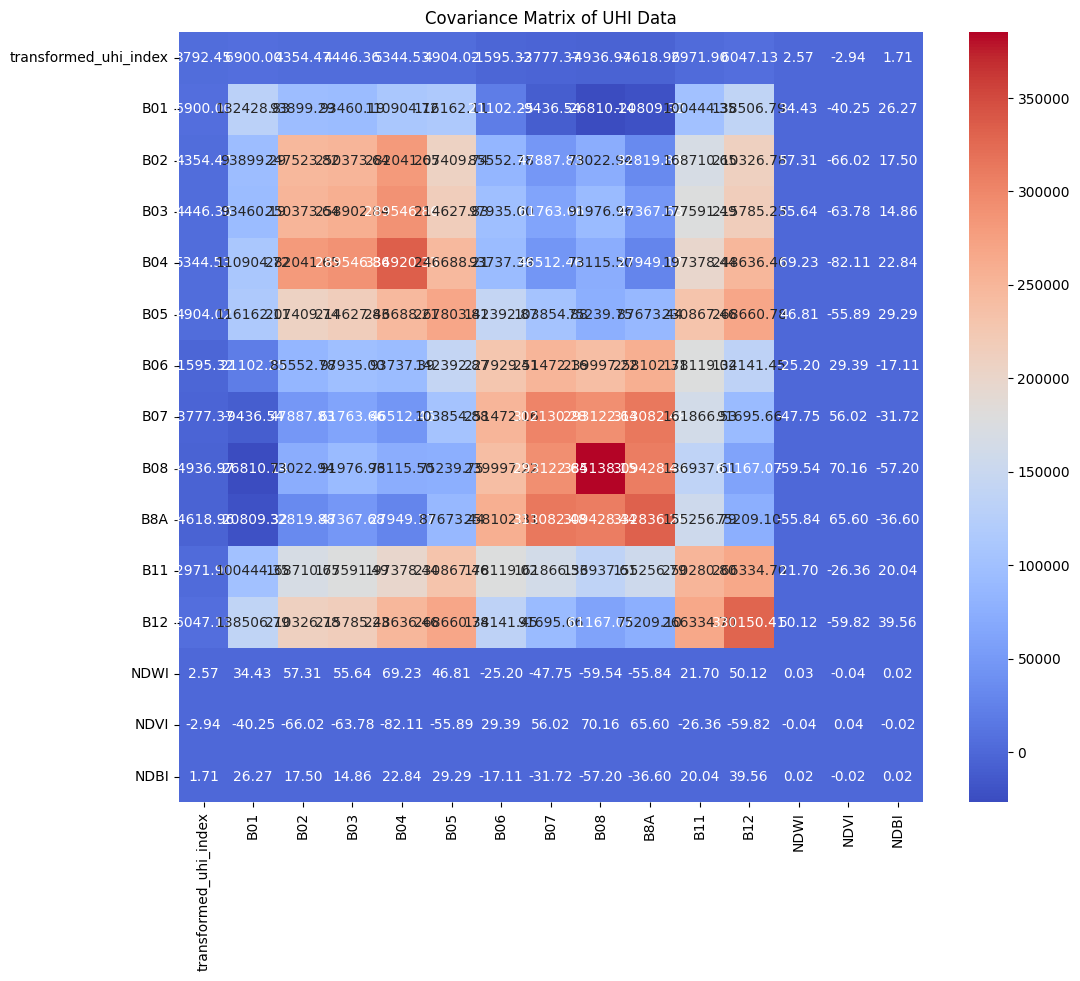

In [ ]:
# prompt: plot covariance matrix for uhi_data[["transformed_uhi_index","B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]] enlarge the plot to make space for the matrix display

import matplotlib.pyplot as plt
# Assuming uhi_data and other necessary libraries are already imported and defined as in the provided code.

# Select relevant columns for covariance matrix
uhi_data_subset = uhi_data[["transformed_uhi_index","B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12","NDWI","NDVI","NDBI"]]

# Calculate the covariance matrix
covariance_matrix = uhi_data_subset.cov()

# Plot the covariance matrix using a heatmap with increased figure size
plt.figure(figsize=(12, 10))  # Increased figure size
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Covariance Matrix of UHI Data')
plt.show()


In [ ]:
# Median Sentinel Data

merge_median = map_satellite_data('median_bands.tiff', 'Training_data_uhi_index.csv',["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"])

# Assuming combine_two_datasets function is defined as in the provided code
combined_data = combine_two_datasets(ground_df, merge_median)

print(combined_data.head())


Mapping B12: 100%|██████████| 11229/11229 [00:15<00:00, 735.31it/s]

   Longitude   Latitude          datetime  UHI Index    B01     B02     B03  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  841.5   646.0   823.0   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  841.5   625.0   766.0   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  841.5   659.5   763.0   

      B04     B05     B06     B07     B08     B8A     B11     B12  
0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  
1  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  
2   777.0  1130.5  1883.0  2117.5  2241.0  2251.0  1548.0  1135.0  
3   741.5  1130.5  1883.0  2117.5  2200.0  2251.0  1548.0  1135.0  
4   708.5  1077.5  1783.0  2042.0  2161.0  2186.0  1617.5  1207.5  


In [ ]:
uhi_data = combined_data

# Trained base on Sentinel
## Use Random Forest
## Use SVD
## Use KNN
## Use Gradient Boost

In [ ]:
# prompt: feauture engineer nvdi, ndbi, and ndwi for uhi_data

import numpy as np
# Assuming uhi_data DataFrame already exists and contains 'B04', 'B08', 'B11', and 'B12' columns.

# Calculate NDVI
uhi_data['NDVI'] = (uhi_data['B08'] - uhi_data['B04']) / (uhi_data['B08'] + uhi_data['B04'])
uhi_data['NDVI'] = uhi_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDBI
uhi_data['NDBI'] = (uhi_data['B11'] - uhi_data['B08']) / (uhi_data['B11'] + uhi_data['B08'])
uhi_data['NDBI'] = uhi_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI
uhi_data['NDWI'] = (uhi_data['B03'] - uhi_data['B08']) / (uhi_data['B03'] + uhi_data['B08'])
uhi_data['NDWI'] = uhi_data['NDWI'].replace([np.inf, -np.inf], np.nan)

print(uhi_data.head())


   Longitude   Latitude          datetime  UHI Index  transformed_uhi_index  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289             114.863919   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289             114.863919   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798              90.246549   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798              90.246549   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634              82.040760   

     B01     B02     B03     B04     B05     B06     B07     B08     B8A  \
0  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0   
1  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0   
2  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  2251.0   
3  841.5   625.0   766.0   741.5  1130.5  1883.0  2117.5  2200.0  2251.0   
4  841.5   659.5   763.0   708.5  1077.5  1783.0  2042.0  2161.0  2186.0   

      B11     B12      NDVI      NDBI      NDWI  
0  1792.0  1495.5 

In [ ]:
# prompt: train a machine learning model to predict "UHI Index" in uhi_data based on ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]. Then calculate accuracy for test set

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12","NDWI","NDVI","NDBI"]]
y = uhi_data["transformed_uhi_index"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set: {accuracy}")


Accuracy (R-squared) on the test set: 0.6164964068682679


In [ ]:
# prompt: train a machine learning model to predict "UHI Index" in uhi_data based on ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]. Then calculate accuracy for test set

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
y = uhi_data["UHI Index"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set: {accuracy}")


Accuracy (R-squared) on the test set: 0.4855563260598921


In [ ]:
# prompt: train a machine learning model to predict "UHI Index" in uhi_data based on ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]. Then calculate accuracy for test set

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B12"]]
y = uhi_data["transformed_uhi_index"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set: {accuracy}")


Accuracy (R-squared) on the test set: 0.6333416374866325


In [ ]:
# prompt: train a machine learning model to predict "UHI Index" in uhi_data based on ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]. Then calculate accuracy for test set

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
y = uhi_data["transformed_uhi_index"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set: {accuracy}")


Accuracy (R-squared) on the test set: 0.6545244608277841


In [ ]:
# prompt: multiply UHI Index column by 1000

uhi_data['UHI Index'] = uhi_data['UHI Index'] * 100


In [ ]:
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI
0,-73.909167,40.813107,24-07-2021 15:53,1030288.903,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5,0.206057,-0.011038,-0.226649
1,-73.909187,40.813045,24-07-2021 15:53,1030288.903,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5,0.206057,-0.011038,-0.226649
2,-73.909215,40.812978,24-07-2021 15:53,1023797.758,841.5,646.0,823.0,777.0,1130.5,1883.0,2117.5,2241.0,2251.0,1548.0,1135.0,0.485089,-0.182898,-0.462794
3,-73.909242,40.812908,24-07-2021 15:53,1023797.758,841.5,625.0,766.0,741.5,1130.5,1883.0,2117.5,2200.0,2251.0,1548.0,1135.0,0.495835,-0.173959,-0.483479
4,-73.909257,40.812845,24-07-2021 15:53,1021634.043,841.5,659.5,763.0,708.5,1077.5,1783.0,2042.0,2161.0,2186.0,1617.5,1207.5,0.506186,-0.143840,-0.478112


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI
0,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5,0.206057,-0.011038,-0.226649
1,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5,0.206057,-0.011038,-0.226649
2,841.5,646.0,823.0,777.0,1130.5,1883.0,2117.5,2241.0,2251.0,1548.0,1135.0,0.485089,-0.182898,-0.462794
3,841.5,625.0,766.0,741.5,1130.5,1883.0,2117.5,2200.0,2251.0,1548.0,1135.0,0.495835,-0.173959,-0.483479
4,841.5,659.5,763.0,708.5,1077.5,1783.0,2042.0,2161.0,2186.0,1617.5,1207.5,0.506186,-0.143840,-0.478112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,462.5,491.0,725.5,501.0,999.0,2612.0,3111.5,3152.0,3446.5,1925.0,1072.5,0.725705,-0.241678,-0.625790
11225,462.5,506.5,741.5,551.5,999.0,2612.0,3111.5,3572.0,3446.5,1925.0,1072.5,0.732509,-0.299618,-0.656196
11226,462.5,506.5,741.5,551.5,999.0,2612.0,3111.5,3572.0,3446.5,1925.0,1072.5,0.732509,-0.299618,-0.656196
11227,462.5,506.5,741.5,551.5,999.0,2612.0,3111.5,3572.0,3446.5,1925.0,1072.5,0.732509,-0.299618,-0.656196


In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
y = uhi_data["UHI Index"]
X = X.astype(float)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train an XGBoost model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.05,  # Learning rate
    max_depth=6,  # Maximum depth of trees
    colsample_bytree=0.9,  # Fraction of features used per tree
    subsample=0.8,  # Subsample ratio of the training set
    random_state=42
)

# Train the model
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy (R-squared) on the test set: {accuracy_xgb}")


XGBoost Accuracy (R-squared) on the test set: 0.33353821197412226


In [ ]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
y = uhi_data["UHI Index"]
X = X.astype(float)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a LightGBM model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error is common for regression
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Fraction of features to choose for each boosting round
}

# Train the model
model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_eval], num_boost_round=100)

# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Evaluate the model's accuracy using R-squared
accuracy_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy (R-squared) on the test set: {accuracy_lgb}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 11
[LightGBM] [Info] Start training from score 1.000008
LightGBM Accuracy (R-squared) on the test set: 0.32743968452067784


In [ ]:
# prompt: train model using svm kernel rbf

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Assuming X and y are defined as in your previous code
# X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
# y = uhi_data["UHI Index"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train an SVR model with RBF kernel
model = SVR(kernel='rbf') # You can adjust hyperparameters like C, gamma, etc.
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set using SVM with RBF kernel: {accuracy}")


Accuracy (R-squared) of SVR model: -0.004630335929070251


In [ ]:
uhi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11229 non-null  float64
 1   Latitude   11229 non-null  float64
 2   datetime   11229 non-null  object 
 3   UHI Index  11229 non-null  float64
 4   B01        11229 non-null  object 
 5   B02        11229 non-null  object 
 6   B03        11229 non-null  object 
 7   B04        11229 non-null  object 
 8   B05        11229 non-null  object 
 9   B06        11229 non-null  object 
 10  B07        11229 non-null  object 
 11  B08        11229 non-null  object 
 12  B8A        11229 non-null  object 
 13  B11        11229 non-null  object 
 14  B12        11229 non-null  object 
 15  NDVI       11229 non-null  float64
 16  NDBI       11229 non-null  float64
 17  NDWI       11229 non-null  float64
dtypes: float64(6), object(12)
memory usage: 1.5+ MB


In [ ]:
a = pd.read_csv('Training_data_uhi_index.csv')
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11229 non-null  float64
 1   Latitude   11229 non-null  float64
 2   datetime   11229 non-null  object 
 3   UHI Index  11229 non-null  float64
dtypes: float64(3), object(1)
memory usage: 351.0+ KB


In [ ]:
# prompt: Please help me write deep neural network model that train the data

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Assuming X and y are defined as in your previous code
X = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]
y = uhi_data["UHI Index"]

#Further preprocessing if needed (e.g., handling missing values)
X.fillna(X.mean(), inplace=True)  # Fill NaN with column means


# Scale the features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the deep neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Mean Squared Error and Mean Absolute Error


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on test data: {mae}")

#Make Predictions
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using R-squared
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy (R-squared) on the test set: {accuracy}")


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 999298826240.0000 - mae: 999515.6250 - val_loss: 994266382336.0000 - val_mae: 996986.2500
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 974174093312.0000 - mae: 986724.8125 - val_loss: 846833123328.0000 - val_mae: 918433.1875
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 754901123072.0000 - mae: 861151.0625 - val_loss: 429607518208.0000 - val_mae: 616310.0000
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 363053285376.0000 - mae: 548409.0000 - val_loss: 286055825408.0000 - val_mae: 457423.0625
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 266461888512.0000 - mae: 440550.9688 - val_loss: 259757801472.0000 - val_mae: 431081.8438
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 233147547648.0000 - mae: 410938.0625 - val_loss: 229816811520.0000 - val_mae: 404065.8125
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 211041976320.0000 - mae: 390372.9